### Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Importing necessary packages

In [ ]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
from tensorflow.keras.utils import to_categorical
from keras.layers import Dense, Dropout, Lambda, BatchNormalization, Input, Conv1D, TimeDistributed, Flatten, Activation, LSTM, Reshape
from keras.models import Model
from keras.callbacks import EarlyStopping, TensorBoard, History, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as KR
import numpy as np
import copy
import time
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
import scipy.stats as ss



 ## --- COMMUNICATION PARAMETERS ---

In [ ]:

blocklength=128 # blocklength of the symbol : n
k = 1 #  code rate K where k is the numerator in R=K/N 
n = 8 # code rate N  where n is the numerator in R=K/N
R = k/n # coding rate R_cod
k_mod = 2  # modulation rate k_mod
print("M= ",blocklength*k_mod/n)
M = int(blocklength*k_mod/n) # Input size (M*k,1)
train_Eb_dB = 5 # Eb/N0 used for training
print(train_Eb_dB+10*np.log10(k_mod))
noise_sigma = np.sqrt(1 / (2 * k_mod  * 10 ** (train_Eb_dB / 10))) # Noise Standard Deviation

batch_size = 500 # Number of messages used for training, each size = k*M
nb_train_word = 100000 # training samples

M=  32.0
8.010299956639813


## --- DATA GENERATION ---

In [ ]:
# Generate training binary Data
train_data = np.random.randint(low=0, high=2, size=(nb_train_word, M*k,1))

In [ ]:
train_data.shape # input shape

(100000, 32, 1)

## --- MODEL HYPERPARAMETERS ---


In [ ]:
early_stopping_patience = 100 # early stopping in training if no improvement
epochs = 100 # number of epochs 
optimizer = Adam(lr=0.001) 
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=early_stopping_patience)
# Learning Rate Control (reduce learing rate if no improvement for a number of iteration)
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.1,
                              patience=10, min_lr=0.000001) 
# Save the best results based on Training Set
modelcheckpoint = ModelCheckpoint(filepath='./' + 'Model ( k_mod=  ' + str(k_mod) + ' k= ' + str(k) + ' n= ' + str(n) + ' SNR= ' + str(train_Eb_dB) + 'dB' + ' ' + 'AWGN)' + '.h5',
                                  monitor='loss',
                                  verbose=1,
                                  save_best_only=True,
                                  save_weights_only=True,
                                  mode='auto', period=1)



/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


## ---DEFINING FUNCTIONS ---

##Normalization Function

In [ ]:
# Define Power Norm for Tx
def equal_power_constraint(x): # average sample per sample ( power of the sample = n)
    #mean=KR.mean(KR.sum(x**2,axis=2),axis=1)
    mean = KR.mean(x ** 2)
    return x / KR.sqrt(2*mean)

def maximum_power_constraint(x): # average sample per sample ( power of the sample <= n)
    norm = KR.sum(KR.sum(x**2,axis=2),axis=1)
    norm_check = tf.where(tf.less_equal(norm,x.shape[1]),tf.ones(x.shape[0]), KR.cast(KR.sqrt(norm/x.shape[1]),'float32'))
    return x / norm_check[:,None,None]

def average_power_constraint(x): # average on all batch samples (power of all batch samples <= n)
  norm = KR.mean(KR.sum(KR.sum(x**2,axis=2),axis=1))
  norm_check = tf.where(tf.less_equal(norm,x.shape[1]),1.0, KR.cast(KR.sqrt(norm/x.shape[1]),'float32'))
  return x / norm_check

def normalize(x): # batch normalization
    x_mean, x_var = tf.nn.moments(x,[0,1])   
    x = (x-x_mean)*1.0/tf.sqrt(2*x_var)
    return x

##Channel Layer

#### AWGN

In [ ]:
# Define Channel Layer including AWGN 
#  x: input data
#  sigma: noise std
def channel_layer(x, sigma):
    w = KR.random_normal(KR.shape(x), mean=0.0, stddev=sigma)
    return x + w



#### Rayleigh ( Not working )

In [ ]:
# Rayleigh fading (Not working)
#def Rayleigh_Channel(x,sigma): 
#      #noise
#      noise = KR.random_normal(KR.shape(x), mean=0.0, stddev=sigma) 
#      # Rayleigh fading
#      uu = KR.random_normal((KR.shape(x)[0],1,1), mean=0.0, stddev=tf.sqrt(0.5),dtype='float32')
#      vv = KR.random_normal((KR.shape(x)[0],1,1), mean=0.0, stddev=tf.sqrt(0.5),dtype='float32') # (500,)*(500,128,2)
#      rayleigh_coeff = tf.sqrt(uu**2 + vv**2)                
#      received = (rayleigh_coeff*x + noise )/rayleigh_coeff
#      return received
#def Complex_Rayleigh_layer(x, sigma):
#    h_i= tf.random.normal(shape=(x.shape[0],1), mean=0.0,stddev=0.5,dtype='float32')
#    h_r= tf.random.normal(shape=(x.shape[0],1), mean=0.0,stddev=0.5,dtype='float32')
#    h_complex = tf.complex(real=h_r, imag=h_i)
#    x_real = tf.cast(x[:, :, 0],dtype='float32')
#    x_imag = tf.cast(x[:, :, 1],dtype='float32')
#    x_complex = tf.complex(real=x_real, imag=x_imag)
#    noise = tf.cast(tf.random.normal(shape=tf.shape(x_complex), mean=0.0, stddev=sigma, dtype=tf.float32),
#                    tf.complex64)
    #noise = tf.complex(
    #    real=tf.random_normal(shape=tf.shape(input_layer_complex), mean=0.0, stddev=std, dtype=tf.float32),
    #    imag=tf.random_normal(shape=tf.shape(input_layer_complex), mean=0.0, stddev=std, dtype=tf.float32))
    #output_complex = tf.multiply(tf.add(tf.multiply(h_complex, x_complex), noise),1/h_complex)
#    output_complex = tf.multiply(tf.add(tf.multiply(h_complex, x_complex), noise),1/tf.cast(tf.abs(h_complex[0])**2,dtype=tf.complex64))

#    output_complex_reshape = tf.reshape(output_complex, [-1, blocklength, 1])
#    return tf.concat([tf.math.real(output_complex_reshape), tf.math.imag(output_complex_reshape)], -1)

##Metrics

In [ ]:
def BER(y, y_pred): # calculate the bit error rate 
  hamming_distances =  tf.cast(tf.not_equal(y, tf.round(y_pred)), tf.int32)
  ber = tf.reduce_sum(hamming_distances) / tf.size(y)
  return ber
  
def BLER(y, y_pred): # calculate the block error rate
    num_blocks_per_batch = tf.cast(tf.shape(y)[0], tf.int32)
    hamming_distances =  tf.cast(tf.not_equal(y, tf.round(y_pred)), tf.int32)
    bler = tf.reduce_sum(tf.cast(tf.reduce_sum(hamming_distances, axis=1)>0,tf.int32)) / num_blocks_per_batch
    return bler

## ---MODEL---

In [ ]:
    #Input
    model_input = Input(batch_shape=(batch_size, M*k,1), name='input_bits') 

    ### ----------------------------------Encoding--------------------------------------
    e = Conv1D(filters=100, strides=k, kernel_size=5,padding="same", name='e_0')(model_input)
    e = BatchNormalization()(e)
    e = Activation('elu')(e)

    e = Conv1D(filters=100, strides=1, kernel_size=5,padding="same")(e)
    e = BatchNormalization()(e)
    e = Activation('elu')(e)

    e = Conv1D(filters=n, strides=1, kernel_size=1 ,padding='same',)(e)
    e = BatchNormalization()(e)
    e = Activation('elu')(e)

    e = Reshape((int(M*n/k_mod),k_mod))(e)

    ### -------------------------Modulation-----------------------------
    e = Conv1D(filters=20, strides=1, kernel_size=5,padding="same", name='e_1',)(e)
    e = BatchNormalization(name='e_2')(e)
    e = Activation('elu', name='e_3')(e)

    e = Conv1D(filters=2, strides=1, kernel_size=1, name='e_4')(e)

    ### ------------------Normalization (different types of power normalization)--------------------

    #e_norm = BatchNormalization(momentum=0, center=False, scale=False)(e)
    e_norm = Lambda(average_power_constraint, name='normalization_layer')(e)
    #e_norm = Lambda(equal_power_constraint, name='normalization_layer')(e)
    #e_norm = Lambda(maximum_power_constraint, name='normalization_layer')(e)
    #e_norm = Lambda(normalize, name='normalization_layer')(e)

    # --------------------------------AWGN channel----------------------------
    #y_h = Lambda(Rayleigh_Channel, arguments={'sigma': noise_sigma}, name='channel_layer')(e_norm)
    y_h = Lambda(channel_layer, arguments={'sigma': noise_sigma})(e_norm)

    # -------------------------------------Demodulation------------------------------
    d = Conv1D(filters=20, strides=1, kernel_size=5,padding="same", name='d_1')(y_h)
    d = BatchNormalization(name='d_2')(d)
    d = Activation('elu', name='d_3')(d)

    d = Conv1D(filters=k_mod, strides=1, kernel_size=1, name='d_4')(d)
    d = BatchNormalization(name='d_5')(d)
    d = Reshape((M,n))(d)


    ### -----------------------------Decoding------------------------
    d = Conv1D(filters=100, strides=1, kernel_size=5,padding="same", name='d_7')(d)
    d = BatchNormalization(name='d_8')(d)
    d = Activation('elu', name='d_9')(d)

    d = Conv1D(filters=100, strides=1, kernel_size=5,padding="same")(d)
    d = BatchNormalization()(d)
    d = Activation('elu')(d)

    d=Conv1D(filters=k,kernel_size=1,padding='same',activation="sigmoid")(d)
    #d = TimeDistributed(Dense(k),name='d_10')(d)
    #d = BatchNormalization(name='d_11')(d)
    model_output = Reshape((M*k,1))(d) # reshape output to input size
    #model_output = Activation('sigmoid', name='d_13')(d)


    # Build System Model
    sys_model = Model(model_input, model_output) # whole model
    encoder = Model(model_input, e) # encoder before normalizing 
    encoder_norm = Model(model_input, e_norm) # encoder after normalizing 

    # Print Model Architecture
    sys_model.summary()

    # Compile Model
    sys_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy',BLER])
    # print('encoder output:', '\n', encoder.predict(vec_one_hot, batch_size=batch_size))



Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_bits (InputLayer)      [(500, 32, 1)]            0         
_________________________________________________________________
e_0 (Conv1D)                 (500, 32, 100)            600       
_________________________________________________________________
batch_normalization_8 (Batch (500, 32, 100)            400       
_________________________________________________________________
activation_8 (Activation)    (500, 32, 100)            0         
_________________________________________________________________
conv1d_8 (Conv1D)            (500, 32, 100)            50100     
_________________________________________________________________
batch_normalization_9 (Batch (500, 32, 100)            400       
_________________________________________________________________
activation_9 (Activation)    (500, 32, 100)            0   

## ---TRAINING----

In [ ]:
# save model if needed
%cd drive/MyDrive/Saved\ models/

[Errno 2] No such file or directory: 'drive/MyDrive/Saved models/'
/content


In [ ]:
print('starting train the NN...')
start = time.clock() 

# TRAINING
mod_history = sys_model.fit(train_data, train_data,
                            batch_size=batch_size,
                            epochs=epochs,
                            verbose=1,
                            callbacks=[modelcheckpoint,reduce_lr])

end = time.clock()

print('The NN has trained ' + str(end - start) + ' s')

In [ ]:
# Plot the Training Loss and Validation Loss
hist_dict = mod_history.history

#val_loss = hist_dict['val_loss']
loss = hist_dict['loss']
acc = hist_dict['accuracy']
# val_acc = hist_dict['val_acc']
#print('loss:',loss)
#print('val_loss:',val_loss)

epoch = np.arange(1, epochs + 1)

#plt.semilogy(epoch,val_loss,label='val_loss')
plt.semilogy(epoch, loss, label='loss')

plt.legend(loc=0)
plt.grid('true')
plt.xlabel('epochs')
plt.ylabel('Binary cross-entropy loss')

plt.show()


#### Testing Normalization layer

In [ ]:
 # testing on small batch (=8) 
a = np.random.randint(low=0, high=2, size=(8,L*k,1)) # generate random input 
out=encoder_norm(a).numpy() # apply encoding + normalization

In [ ]:
(((out**2)).sum(axis=2).sum(axis=1)).mean() # calculate the power of the whole batch

128.0

## --- TESTING DATA GENERATION ---

In [ ]:
nb_test_word = 100000 # Testing data size
test_data = np.random.randint(low=0, high=2, size=(nb_test_word, M*k,1)) # generate random binary data

## --- Simulation ---

#### Testing at a specific SNR

HERE WE CHOOSE THE SPECIFIC Eb_N0_dB WE WANT TO TEST THE TRAINED MODEL ON. WE CHOOSE A CLOSE VALUE TO THE TRAINING Eb_N0 AND WE CHECK IF IT SATISFIES ϵ = $10^{-2}$. IF NOT WE CHANGE THE Eb_N0_dB UNTIL WE FIND THE ONE THAT SATISFIES THAT ERROR ϵ 

In [ ]:
    Eb_N0_dB=6.5
    # Noise Sigma at this Eb
    noise_sigma = np.sqrt(1 / (2  * k_mod * R * 10 ** (Eb_N0_dB / 10))) # Noise Standard Deviation


    model_input = Input(batch_shape=(batch_size, M*k,1), name='input_bits')

    ### --------------------------Encoding-----------------------------------
    e = Conv1D(filters=100, strides=k, kernel_size=5,padding="same", name='e_0')(model_input)
    e = BatchNormalization()(e)
    e = Activation('elu')(e)

    e = Conv1D(filters=100, strides=1, kernel_size=5,padding="same")(e)
    e = BatchNormalization()(e)
    e = Activation('elu')(e)

    e = Conv1D(filters=n, strides=1, kernel_size=1 ,padding='same',)(e)
    e = BatchNormalization()(e)
    e = Activation('elu')(e)

    e = Reshape((int(M*n/k_mod),k_mod))(e)

    ### -----------------------------Modulation-----------------------------
    e = Conv1D(filters=20, strides=1, kernel_size=5,padding="same", name='e_1',)(e)
    e = BatchNormalization(name='e_2')(e)
    e = Activation('elu', name='e_3')(e)

    e = Conv1D(filters=2, strides=1, kernel_size=1, name='e_4')(e)

    ### ---------------------Normalization---------------------------
    #e_norm = BatchNormalization(momentum=0, center=False, scale=False)(e)
    e_norm = Lambda(average_power_constraint, name='normalization_layer')(e)
    #e_norm = Lambda(equal_power_constraint, name='normalization_layer')(e)
    #e_norm = Lambda(maximum_power_constraint, name='normalization_layer')(e)
    #e_norm = Lambda(normalize, name='normalization_layer')(e)

    #---------------------------- AWGN channel--------------------------
    #y_h = Lambda(Rayleigh_Channel, arguments={'sigma': noise_sigma}, name='channel_layer')(e_norm)
    y_h = Lambda(channel_layer, arguments={'sigma': noise_sigma})(e_norm)

    # ------------------------------Demodulation-----------------
    d = Conv1D(filters=20, strides=1, kernel_size=5,padding="same", name='d_1')(y_h)
    d = BatchNormalization(name='d_2')(d)
    d = Activation('elu', name='d_3')(d)

    d = Conv1D(filters=k_mod, strides=1, kernel_size=1, name='d_4')(d)
    d = BatchNormalization(name='d_5')(d)
    d = Reshape((M,n))(d)


    ###----------------------------- Decoding --------------------------
    d = Conv1D(filters=100, strides=1, kernel_size=5,padding="same", name='d_7')(d)
    d = BatchNormalization(name='d_8')(d)
    d = Activation('elu', name='d_9')(d)

    d = Conv1D(filters=100, strides=1, kernel_size=5,padding="same")(d)
    d = BatchNormalization()(d)
    d = Activation('elu')(d)

    d=Conv1D(filters=k,kernel_size=1,padding='same',activation="sigmoid")(d)
    #d = TimeDistributed(Dense(k),name='d_10')(d)
    #d = BatchNormalization(name='d_11')(d)
    model_output = Reshape((M*k,1))(d)
    #model_output = Activation('sigmoid', name='d_13')(d)

     
    # Build the model
    model = Model(inputs=model_input, outputs=model_output)

    encoder = Model(model_input,e)
    # Load Weights from the trained NN
    model.load_weights('./' + 'Model ( k_mod=  ' + str(k_mod) + ' k= ' + str(k) + ' n= ' + str(n) + ' SNR= ' + str(train_Eb_dB) + 'dB' + ' ' + 'AWGN)' + '.h5',
                       by_name=False)

    '''
    RUN THE NN
    '''

    # RUN Through the Model and get output
    decoder_output = model.predict(test_data, batch_size=batch_size)

    '''
     --- CALULATE BLER ---
    '''


    bler = BLER(test_data,decoder_output).numpy()
    print('Eb/N0 = ', Eb_N0_dB,'BLER = ', bler)




### BER

Show the BER values for a range of SNR ( e.g. 0-20 dB).

In [ ]:



'''
 --- DEFINE THE Neural Network(NN) ---
'''
Vec_Eb_N0 = []
Bit_error_rate = []
# Eb_N0 in dB
for Eb_N0_dB in range(0,11):

    # Noise Sigma at this Eb
    noise_sigma = np.sqrt(1 / (2  * k_mod * 10 ** (Eb_N0_dB / 10))) # Noise Standard Deviation


    model_input = Input(batch_shape=(batch_size, M*k,1), name='input_bits')

    ### Encoding
    e = Conv1D(filters=100, strides=k, kernel_size=5,padding="same", name='e_0')(model_input)
    e = BatchNormalization()(e)
    e = Activation('elu')(e)

    e = Conv1D(filters=100, strides=1, kernel_size=5,padding="same")(e)
    e = BatchNormalization()(e)
    e = Activation('elu')(e)

    e = Conv1D(filters=n, strides=1, kernel_size=1 ,padding='same',)(e)
    e = BatchNormalization()(e)
    e = Activation('elu')(e)

    e = Reshape((int(M*n/k_mod),k_mod))(e)

    ### Modulation
    e = Conv1D(filters=20, strides=1, kernel_size=5,padding="same", name='e_1',)(e)
    e = BatchNormalization(name='e_2')(e)
    e = Activation('elu', name='e_3')(e)

    e = Conv1D(filters=2, strides=1, kernel_size=1, name='e_4')(e)

    ### Normalization
    #e_norm = BatchNormalization(momentum=0, center=False, scale=False)(e)
    e_norm = Lambda(average_power_constraint, name='normalization_layer')(e)
    #e_norm = Lambda(equal_power_constraint, name='normalization_layer')(e)
    #e_norm = Lambda(maximum_power_constraint, name='normalization_layer')(e)
    #e_norm = Lambda(normalize, name='normalization_layer')(e)

    # AWGN channel
    #y_h = Lambda(Rayleigh_Channel, arguments={'sigma': noise_sigma}, name='channel_layer')(e_norm)
    y_h = Lambda(channel_layer, arguments={'sigma': noise_sigma})(e_norm)

    # Demodulation
    d = Conv1D(filters=20, strides=1, kernel_size=5,padding="same", name='d_1')(y_h)
    d = BatchNormalization(name='d_2')(d)
    d = Activation('elu', name='d_3')(d)

    d = Conv1D(filters=k_mod, strides=1, kernel_size=1, name='d_4')(d)
    d = BatchNormalization(name='d_5')(d)
    d = Reshape((M,n))(d)


    ### Decoding 
    d = Conv1D(filters=100, strides=1, kernel_size=5,padding="same", name='d_7')(d)
    d = BatchNormalization(name='d_8')(d)
    d = Activation('elu', name='d_9')(d)

    d = Conv1D(filters=100, strides=1, kernel_size=5,padding="same")(d)
    d = BatchNormalization()(d)
    d = Activation('elu')(d)

    d=Conv1D(filters=k,kernel_size=1,padding='same',activation="sigmoid")(d)
    #d = TimeDistributed(Dense(k),name='d_10')(d)
    #d = BatchNormalization(name='d_11')(d)
    model_output = Reshape((M*k,1))(d)
    #model_output = Activation('sigmoid', name='d_13')(d)
    # Build the model
    model = Model(inputs=model_input, outputs=model_output)

    encoder = Model(model_input,e)
    # Load Weights from the trained NN
    model.load_weights('./' + 'Model ( k_mod=  ' + str(k_mod) + ' k= ' + str(k) + ' n= ' + str(n) + ' SNR= ' + str(train_Eb_dB) + 'dB' + ' ' + 'AWGN)' + '.h5',
                       by_name=False)

    '''
    RUN THE NN
    '''

    decoder_output = model.predict(test_data, batch_size=batch_size)

    '''
     --- CALULATE BER ---
    '''


    ber = BER(test_data,decoder_output).numpy()
    print('Eb/N0 = ', Eb_N0_dB,'BER = ', ber)


    # Store The Results
    Vec_Eb_N0.append(Eb_N0_dB)
    Bit_error_rate.append(ber)





## BLER
Show the BER values for a range of SNR ( e.g. 0-20 dB).

In [ ]:

'''
 --- DEFINE THE Neural Network(NN) ---
'''
Vec_Eb_N0 = []
Block_error_rate = []
# Eb_N0 in dB
for Eb_N0_dB in range(0,11):

    # Noise Sigma at this Eb
    noise_sigma = np.sqrt(1 / (2  * k_mod * 10 ** (Eb_N0_dB / 10))) # Noise Standard Deviation


    model_input = Input(batch_shape=(batch_size, M*k,1), name='input_bits')

    ### Encoding
    e = Conv1D(filters=100, strides=k, kernel_size=5,padding="same", name='e_0')(model_input)
    e = BatchNormalization()(e)
    e = Activation('elu')(e)

    e = Conv1D(filters=100, strides=1, kernel_size=5,padding="same")(e)
    e = BatchNormalization()(e)
    e = Activation('elu')(e)

    e = Conv1D(filters=n, strides=1, kernel_size=1 ,padding='same',)(e)
    e = BatchNormalization()(e)
    e = Activation('elu')(e)

    e = Reshape((int(M*n/k_mod),k_mod))(e)

    ### Modulation
    e = Conv1D(filters=20, strides=1, kernel_size=5,padding="same", name='e_1',)(e)
    e = BatchNormalization(name='e_2')(e)
    e = Activation('elu', name='e_3')(e)

    e = Conv1D(filters=2, strides=1, kernel_size=1, name='e_4')(e)

    ### Normalization
    #e_norm = BatchNormalization(momentum=0, center=False, scale=False)(e)
    e_norm = Lambda(average_power_constraint, name='normalization_layer')(e)
    #e_norm = Lambda(equal_power_constraint, name='normalization_layer')(e)
    #e_norm = Lambda(maximum_power_constraint, name='normalization_layer')(e)
    #e_norm = Lambda(normalize, name='normalization_layer')(e)

    # AWGN channel
    #y_h = Lambda(Rayleigh_Channel, arguments={'sigma': noise_sigma}, name='channel_layer')(e_norm)
    y_h = Lambda(channel_layer, arguments={'sigma': noise_sigma})(e_norm)

    # Demodulation
    d = Conv1D(filters=20, strides=1, kernel_size=5,padding="same", name='d_1')(y_h)
    d = BatchNormalization(name='d_2')(d)
    d = Activation('elu', name='d_3')(d)

    d = Conv1D(filters=k_mod, strides=1, kernel_size=1, name='d_4')(d)
    d = BatchNormalization(name='d_5')(d)
    d = Reshape((M,n))(d)


    ### Decoding 
    d = Conv1D(filters=100, strides=1, kernel_size=5,padding="same", name='d_7')(d)
    d = BatchNormalization(name='d_8')(d)
    d = Activation('elu', name='d_9')(d)

    d = Conv1D(filters=100, strides=1, kernel_size=5,padding="same")(d)
    d = BatchNormalization()(d)
    d = Activation('elu')(d)

    d=Conv1D(filters=k,kernel_size=1,padding='same',activation="sigmoid")(d)
    #d = TimeDistributed(Dense(k),name='d_10')(d)
    #d = BatchNormalization(name='d_11')(d)
    model_output = Reshape((M*k,1))(d)
    #model_output = Activation('sigmoid', name='d_13')(d)

     
    # Build the model
    model = Model(inputs=model_input, outputs=model_output)

    encoder = Model(model_input,e)
    # Load Weights from the trained NN
    model.load_weights('./' + 'Model ( k_mod=  ' + str(k_mod) + ' k= ' + str(k) + ' n= ' + str(n) + ' SNR= ' + str(train_Eb_dB) + 'dB' + ' ' + 'AWGN)' + '.h5',
                       by_name=False)

    '''
    RUN THE NN
    '''

    # RUN Through the Model and get output
    decoder_output = model.predict(test_data, batch_size=batch_size)

    '''
     --- CALULATE BLER ---
    '''

    bler = BLER(test_data,decoder_output).numpy()
    print('Eb/N0 = ', Eb_N0_dB,'BLER = ', bler)


    # Store The Results
    Vec_Eb_N0.append(Eb_N0_dB)
    Block_error_rate.append(bler)

Eb/N0 =  0 BLER =  0.87576
Eb/N0 =  1 BLER =  0.74179
Eb/N0 =  2 BLER =  0.5544
Eb/N0 =  3 BLER =  0.35079
Eb/N0 =  4 BLER =  0.17522
Eb/N0 =  5 BLER =  0.06888
Eb/N0 =  6 BLER =  0.02089
Eb/N0 =  7 BLER =  0.00454
Eb/N0 =  8 BLER =  0.00084
Eb/N0 =  9 BLER =  7e-05
Eb/N0 =  10 BLER =  1e-05


## --- PLOTTING ---

### BER

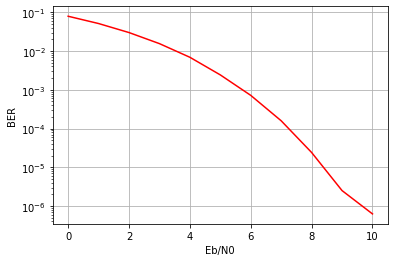

In [ ]:
plt.semilogy(Vec_Eb_N0, Bit_error_rate, color='red')
plt.xlabel('Eb/N0')
plt.ylabel('BER')
plt.grid('true')
plt.show()

### BLER

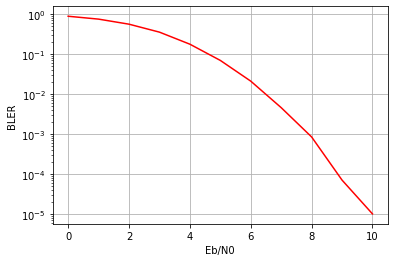

In [ ]:
plt.semilogy(Vec_Eb_N0, Block_error_rate, color='red')
plt.xlabel('Eb/N0')
plt.ylabel('BLER')
plt.grid('true')
plt.show()